In [1]:
import model
import numpy as np
import random
import tank
import truck

import gym_pdsystem

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
from IPython.display import HTML


import time

from gym_pdsystem.envs.pdsystem_env import PDSystemEnv
import gym_pdsystem.utils.utilsq as ut
import gym_pdsystem.utils.constants as ct
import gym_pdsystem.utils.functions as fnc

import os

simulations_directory = './simulations'
if not os.path.exists(simulations_directory):
    os.makedirs(simulations_directory)


In [2]:
COEFF = ct.COEFF

C_TRANSPORT = ct.C_TRANSPORT
C_LEVELS = ct.C_LEVELS

p0_GLOBAL = ct.p0_GLOBAL

P1_GLOBAL = ct.P1_GLOBAL
P2_GLOBAL = ct.P2_GLOBAL

M_GLOBAL = ct.M_GLOBAL

NOT_DELIVERYING_PENALTY = P2_GLOBAL #to be equivalent/same importance as having 0 stock or surpassing max capacity levels


## System initializer

In [3]:
def initialize_test_system(seed = None):
    if seed != None:
        np.random.seed(seed)

    # Tanks' information
    global n
    n = 5 
    tank_ids = list(range(1,n+1))
    tank_max_loads =  np.array([100., 200, 100., 800., 200.])

    tank_current_loads = np.full(n,0)
    tank_consumption_rates =  np.array([5.] * n)
    noisy_consumption_rate = True
    
    global n_discrete_load_levels
    n_discrete_load_levels = np.array([4,4,4,4,4])
    
    load_level_percentages = np.array([ #b , c, e
                                            [0.02, 0.31, 0.9],
                                            [0.01, 0.03, 0.9],
                                            [0.05, 0.16, 0.9],
                                            [0.07, 0.14, 0.85],
                                            [0.08, 0.26, 0.9]
                                               ])
        
    for i, (lvl, max_load) in enumerate(zip(n_discrete_load_levels, tank_max_loads)):
        a = np.linspace(0,max_load, lvl+1)[1]
        current_load = np.random.randint(a+1,max_load)
        tank_current_loads[i] = current_load     

    # Trucks' information
    global k
    k = 2
    truck_ids = list(range(k))
    truck_max_loads = np.array([70.,130.])
    truck_current_loads = truck_max_loads.copy()
    truck_current_positions =  np.array([5] * k)
    #truck_fractions_deliverable =  np.array([1.] * k) # we for now we only allow to deliver all the content of the truck
    truck_fractions_deliverable =  np.array([ np.array([1.]), 
                                              np.array([1.])
                                            ]) # we for now we only allow to deliver all the content of the truck
    global n_discrete_load_levels_trucks
    n_discrete_load_levels_trucks = np.array([1,1])

    # System's information
   
    graph = ut.simple_graph(n+1)
    tanks = [tank.Tank( tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls, noisy_consumption_rate) 
             for  tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls in 
             zip( tank_ids, tank_current_loads, tank_max_loads, tank_consumption_rates, n_discrete_load_levels,
                  load_level_percentages)]
    trucks = [truck.Truck( truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls) 
             for  truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls in 
             zip(truck_ids, truck_current_loads, truck_max_loads, truck_current_positions, 
                 truck_fractions_deliverable, n_discrete_load_levels_trucks)]

    w =  np.array([32., 159., 162., 156.,156., 0.])

    weights_matrix = ut.simple_weights(n+1, w)
    
    return(tanks, trucks, graph, weights_matrix)

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

# Action-State space dimension
a_s_dim = toy_system.states_dim * toy_system.actions_dim
a_s_dim

368640

In [4]:
tanks, trucks, graph, weights_matrix = initialize_test_system(seed = 42)
system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)
print(system.tank_loads())
print(system.graph)
print(system.weights)

[77, 143, 40, 307, 122]
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 1]]
[[ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ 32. 159. 162. 156. 156.   0.]]


### Reinitialize system function

In [5]:
def reinitialize_system(system, seed = None):
    if seed != None:
        np.random.seed(seed)
        
    for tank, tank_levels in zip(system.tanks, system.tanks_level):
        a = tank_levels[0]
        b = tank_levels[-1]
        current_load = np.random.randint(a+1,b)*1.0
        tank.load = current_load
    system.reset_trucks_positions(); 
    return(system)    

## Q-learning algorithm (off-policy)


### Training

In [6]:
# Retrain parameters:
retrain = False

episode_retrain = 2*10**3
retrain_episodes = 1*10**3


# Train parameters:
train_epsilon = True

learning_rate0 = 1 #0.05
learning_rate_decay = 0 #0.01

episodes = 10**3 #episodes 40*
episodes_epsilon_min = 10**2
train_freq = 10**2 # 10**4
train_vis_freq =  10**3
train_rew_freq =  10**2
train_Q_freq =  10**3
episode_length = 30

discount_rate = 1

epsilon0 = 1.0
epsilon_decay =( 1./(episodes_epsilon_min) ) 
epsilon_min = 0.05

verbose = False
verbose_info = False

seed = 42

train_visualization_steps = []
train_rewards_list = []

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = {}

simulation_id = 3

# Create directories for the simulations' outputs

simulation_directory = './simulations/simulation{}'.format(simulation_id)
if not os.path.exists(simulation_directory):
    os.makedirs(simulation_directory)
    os.makedirs(simulation_directory + '/Q-dictionaries')
    os.makedirs(simulation_directory + '/discrewards')
    os.makedirs(simulation_directory + '/vis')
    
else:
    raise Exception("The simulation id you tried to use has been already used before. Try to change it to a new one.")

    
ut.save_obj(toy_system, simulation_directory+"/system-sim"+f"{simulation_id}")    

# if retrain == True:
#     simulation_id_retrain = 3
#     iteration_retrain = 50*10**6
#     Q = ut.load_obj("Q-dict-sim" + f"{simulation_id_retrain}" + "-" + f"{iteration_retrain}")



In [7]:
def episodic_train_Q_epsilon( 
            epsilon0 = epsilon0,
            epsilon_min = epsilon_min,
            n_episodes = episodes, 
            episode_length = episode_length,
            learning_rate0 = learning_rate0,
            learning_rate_decay = learning_rate_decay,
            discount_rate = discount_rate,
            system = toy_system,
            Q = Q, verbose = verbose, verbose_info = verbose_info,
            visualization_steps = train_visualization_steps, rewards_list = train_rewards_list,
            seed = seed, 
            freq = train_freq,
            vis_freq = train_vis_freq,
            rew_freq = train_rew_freq,
            Q_freq = train_Q_freq,
            simulation_id = simulation_id,
            round_time = 2
    
           ):
    
    time_start = time.time()
    
    for episode in range(1,n_episodes+1):
        print("\rEpisode: {}".format(episode), end="")

        reinitialize_system(system, seed = episode)
        
        ### epsilon-greedy exploration
        epsilon = max( epsilon_min, epsilon0 / (1+(episode-1)*epsilon_decay) ) 
        
        ### decrement of learning rate
        learning_rate = learning_rate0 / (1+(episode-1)*learning_rate_decay)        

        discounted_reward = 0
        
        for t in range(episode_length):

            system.update_state()
            s_current = system.state_to_string()                
            p = np.random.uniform()

            if p > epsilon:
                #DETERMINISTIC ACTION OPTIMAL
                s0 = system.state_to_string()
                best_action = optimal_policy(s0, Q)
                if best_action == None:
                    reward = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)
                else:
                    reward = system.deterministic_action(best_action)
                #print(best_action)
            else:
                reward = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)

            a_current = system.action_to_string()
            sa_current = ''.join([s_current, a_current])

            system.update_state()
            sa_new = system.state_action_to_string()

            if ut.is_key(Q, sa_current) == False:
                Q[sa_current] = 0

            Q_max = max([Q[key] for key in Q.keys() if key.startswith(sa_new[0:system.state_length])]+[0.0]) 

            if Q[sa_current] != -np.inf:
                Q[sa_current] = ( (1-learning_rate) * Q[sa_current] 
                                 + learning_rate* (reward + discount_rate * Q_max)
                                )
                
            discounted_reward = discounted_reward + (discount_rate**t) * reward
            system.reset_trucks_positions();     
            system.reset_trucks_loads();
            
        rewards_list.append(discounted_reward);
        if episode % freq == 0:
                time_end = time.time()
                print(". Elapsed time ", round( (time_end-time_start)/60., round_time), " minuts.",
                      "epsilon", round(epsilon,4), 
                     "Discounted reward: ", discounted_reward)
                
                if verbose_info:
                    print("s, a", system.s, system.a)
                    print("ds, da", system.ds, system.da)
        if episode % Q_freq == 0:           
                ut.save_obj(Q, simulation_directory +"/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episode}")   

        if episode % vis_freq == 0:
                #Save visualization and rewards
                visualization_steps.append(toy_system.visualize());
                ut.save_obj(visualization_steps, simulation_directory +"/vis/vis-train-sim" + f"{simulation_id}" + "-" + f"{episode}")   
                                
        if episode % rew_freq == 0:
            #rewards_list.append(discounted_reward);
                ut.save_obj(rewards_list, simulation_directory +"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")
                
    end_time = round(time.time()-time_start,round_time)        
    print(f"Training finished. Total episodes: {n_episodes}. Elapsed time: {round(end_time/60., round_time)} minutes.")        

In [8]:
# Given a state, returns the action that has the highest Q-value.

def optimal_policy(state, Q, system = toy_system):
    """
    state must be in the string-integers code
    """
    state_keys = [key for key in list(Q) if key.startswith(state)]
    if len(state_keys) == 0:
        return(None)
    
    state_q = [Q[state_key] for state_key in state_keys]
    
    #print("state_q ", state_q[1:min(10,len(state_q))])
    
    max_q = max(state_q)
    #print("max_q", max_q)
    optimal_key_index = np.where(np.isin(state_q, max_q ))[0][0]
    #print("optimal_key_index", optimal_key_index)
    optimal_key = state_keys[optimal_key_index]
    #print("optimal_key", optimal_key)
    optimal_action = optimal_key[system.state_length:]
    
    return(optimal_action)
    

In [9]:
if train_epsilon == True and retrain == False:
    episodic_train_Q_epsilon()
elif train_epsilon == False and retrain == True:
    Q_retrain = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episode_retrain}")
    episodic_train_Q_epsilon(n_episodes = retrain_episodes, Q = Q_retrain)
else:
    raise Exception("Only one of the parameters train_epsilon or retrain parameters can be set to True.")
    
    

Episode: 100. Elapsed time  0.05  minuts. epsilon 0.5025 Discounted reward:  -18000033.008006
Episode: 200. Elapsed time  0.12  minuts. epsilon 0.3344 Discounted reward:  -10000015.0270175
Episode: 300. Elapsed time  0.19  minuts. epsilon 0.2506 Discounted reward:  -4000027.000789937
Episode: 400. Elapsed time  0.27  minuts. epsilon 0.2004 Discounted reward:  -6000004.036557288
Episode: 500. Elapsed time  0.36  minuts. epsilon 0.1669 Discounted reward:  -3000005.0267283157
Episode: 600. Elapsed time  0.46  minuts. epsilon 0.1431 Discounted reward:  -3000007.004646487
Episode: 700. Elapsed time  0.56  minuts. epsilon 0.1252 Discounted reward:  -1000003.0370675306
Episode: 800. Elapsed time  0.66  minuts. epsilon 0.1112 Discounted reward:  -3000007.007663468
Episode: 900. Elapsed time  0.78  minuts. epsilon 0.1001 Discounted reward:  -5000010.315892206
Episode: 1000. Elapsed time  0.9  minuts. epsilon 0.091 Discounted reward:  -4000009.0529886945
Training finished. Total episodes: 1000. 

### Testing

In [10]:
# TEST PARAMETERS AND INITIALIZATION

# Initialize system
tanks, trucks, graph, weights_matrix = initialize_test_system(seed =100000)
test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)
    
Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episodes}")


test_episodes = 5
episode_length =30
test_freq = 1
test_verbose = False

test_visualization_steps = []
test_rewards_list = []

In [11]:
def test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           freq = test_freq,
           test_verbose = test_verbose
           
          ):
    
    for episode in range(1,n_episodes+1): 
        print("\rTest episode: {}".format(episode), end="")
        reinitialize_system(system, seed = episode+episodes)

        discounted_reward = 0      
        
        for i in range(1,episode_length+1):
            #print("state", test_toy_system.s, test_toy_system.ds)
            system.update_state()

            #Save visualization steps
            if i % freq == 0:
                visualization_steps.append(system.visualize());

            s0 = system.state_to_string()
            best_action = optimal_policy(s0, Q)
            #print("best_action", best_action)

            if best_action == None:
                reward = system.random_action()
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t", i-1, reward, " Random action is performed. Current state unknown for Q.")

            else:
                reward = system.deterministic_action(best_action)
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t",i-1,reward, best_action)

            system.reset_trucks_positions();
            system.reset_trucks_loads();
            
            discounted_reward = discounted_reward + (discount_rate**(i-1)) * reward
            if reward <= P2_GLOBAL:
                print("\rSome tank is in a forbidden level")

        system.reset_trucks_positions();
        
        #Save rewards
        if episode % freq == 0:
            rewards_list.append(discounted_reward);


In [12]:
test_Q()
#print(np.mean(test_rewards_list) )

Test episode: 5

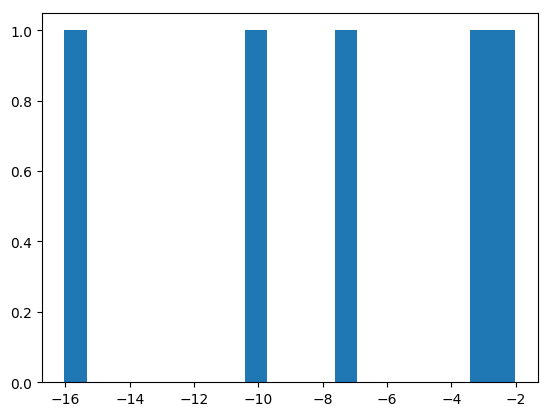

In [13]:
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)
plt.hist(test_rewards_list, bins = 20)
plt.show()

In [14]:
# Visualizing test simulation:

test_anim = ut.create_system_animation(test_visualization_steps, test_episodes * episode_length,test_freq)
HTML(test_anim.to_html5_video())


In [15]:
# Visualizing train simulation:

episode =episodes
#simulation_id = 2
step = 30
discrewards_list = ut.load_obj(simulation_directory+"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")

discrewards_list2 = [discrewards_list[i] for i in range(0,len(discrewards_list),step)]

p = plt.plot([i for i in range(0,len(discrewards_list),step)], 
             discrewards_list2)

#plt.show()
plt.savefig(simulation_directory+'/discrewards-sim' + f'{simulation_id}' + '.png')

In [16]:
len(list(Q))

4886

In [17]:
tank_levels = [test_visualization_steps[i][2] for i in range(len(test_visualization_steps))]
tank_levels_array = np.asarray(tank_levels).transpose()

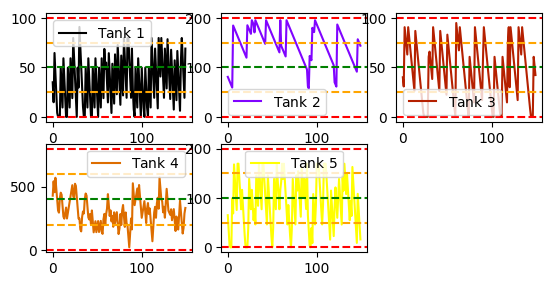

In [18]:
#DISCRETE LEVELS

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, n)]
lvl_colors = ["Orange", "Green","Orange"]

tanks = test_toy_system.tanks

for i, color in enumerate(colors, start=1):
    plt.subplot(3,3, i)    
    plt.plot(tank_levels_array[i-1], color=color, label='Tank ${i}$'.format(i=i))
    
    plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    for lvl_color, lvl in zip(lvl_colors, tanks[i-1].levels):
        plt.axhline(y= lvl, xmin=0, xmax=episode_length, hold=None, color = lvl_color, linestyle = '--')
    plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')


    plt.legend(loc='best')
plt.show()

        

In [19]:
#THE REAL LEVELS (percentages 12h, 36h, ? h)

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, n)]
lvl_colors = ["Orange", "Green","Orange"]

tanks = test_toy_system.tanks

for i, color in enumerate(colors, start=1):
    plt.subplot(3,3, i)    

    plt.plot(tank_levels_array[i-1], color=color, label='Tank ${i}$'.format(i=i))
    
    plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    for lvl_color, lvl in zip(lvl_colors, tanks[i-1].level_percentages):
        plt.axhline(y= lvl * tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                    linestyle = '--')
    plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    
    
    percentages = tanks[i-1].level_percentages           
    c = percentages[1]
    e = percentages[2]          
    d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
    plt.axhline(y= d*tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                linestyle = '-.')

    plt.axhline(y= np.mean(tank_levels_array[i-1]), xmin=0, xmax=episode_length, hold=None, 
                color = "blue", linestyle = '-.')
  


    plt.legend(loc='best')
#plt.show()
plt.savefig(simulation_directory + '/tank-levels-sim' + f'{simulation_id}' + '.pdf')